In [45]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, KFold

from sklearn.utils.multiclass import type_of_target

from sklearn import preprocessing

import re

In [2]:
def metric(y_true, y_pred):
    
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

In [3]:
df = pd.read_csv('E:\\Vakansy\\magnit\\data_regression_for_task.csv')
df.dropna(inplace=True)

In [4]:
df.isna().sum()

YEAR             0
MONTH            0
CONTRAGENT       0
ARTICLE_CODE     0
ARTICLE_NAME     0
ARTICLE_GROUP    0
SALES            0
STORE_SALES      0
dtype: int64

In [5]:
df#.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0
...,...,...,...,...,...,...,...,...
128348,2018,2,LEGENDS LTD,99753,DUTCHESS DE BOURGOGNE NR - 750ML,BEER,0.0,2.0
128349,2018,2,COASTAL BREWING COMPANY LLC,99813,DOMINION OAK BARREL STOUT 1/2K,KEGS,0.0,2.0
128350,2018,2,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,66460.0,212.0
128351,2018,2,COASTAL BREWING COMPANY LLC,99970,DOMINION OAK BARREL STOUT 4/6 NR - 12OZ,BEER,9080.0,35.0


In [6]:
df.columns

Index(['YEAR', 'MONTH', 'CONTRAGENT', 'ARTICLE_CODE', 'ARTICLE_NAME',
       'ARTICLE_GROUP', 'SALES', 'STORE_SALES'],
      dtype='object')

In [7]:
len(df['CONTRAGENT'].unique()), len(df['ARTICLE_CODE'].unique()), len(df['ARTICLE_NAME'].unique()), len(df['ARTICLE_GROUP'].unique())

(333, 23552, 23620, 8)

In [8]:
df['ARTICLE_GROUP'].unique()

array(['WINE', 'LIQUOR', 'BEER', 'STR_SUPPLIES', 'REF', 'NON-ALCOHOL',
       'KEGS', 'DUNNAGE'], dtype=object)

In [9]:
df['YEAR'].unique()

array([2017, 2018], dtype=int64)

In [10]:
df['SALES'].describe()

count    1.283300e+05
mean     6.564316e+03
std      2.892762e+04
min     -6.490000e+03
25%      0.000000e+00
50%      3.300000e+02
75%      3.250000e+03
max      1.616600e+06
Name: SALES, dtype: float64

In [11]:
df['STORE_SALES'].describe()

count    128330.000000
mean         22.681679
std         239.574553
min       -4996.000000
25%           0.000000
50%           1.000000
75%           4.000000
max       16271.750000
Name: STORE_SALES, dtype: float64

In [12]:
ohe = OneHotEncoder(categories = "auto",sparse = False)
df.dropna(inplace=True)
tp=ohe.fit_transform(df[['ARTICLE_GROUP']])
tp_col=pd.DataFrame(tp, columns=[df['ARTICLE_GROUP'].unique()])
df = pd.concat([df,tp_col],axis = 1)
df.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,"(WINE,)","(LIQUOR,)","(BEER,)","(STR_SUPPLIES,)","(REF,)","(NON-ALCOHOL,)","(KEGS,)","(DUNNAGE,)"
0,2017.0,4.0,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2017.0,4.0,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2017.0,4.0,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2017.0,4.0,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2017.0,4.0,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
df.columns

Index([           'YEAR',           'MONTH',      'CONTRAGENT',
          'ARTICLE_CODE',    'ARTICLE_NAME',   'ARTICLE_GROUP',
                 'SALES',     'STORE_SALES',         ('WINE',),
             ('LIQUOR',),         ('BEER',), ('STR_SUPPLIES',),
                ('REF',),  ('NON-ALCOHOL',),         ('KEGS',),
            ('DUNNAGE',)],
      dtype='object')

In [14]:
df.isna().sum()
df.dropna(inplace=True)

In [15]:
xtrain, xtest, ytrain, ytest=train_test_split(df[[           'YEAR',           'MONTH',           'STORE_SALES',         ('WINE',),
             ('LIQUOR',),         ('BEER',), ('STR_SUPPLIES',),
                ('REF',),  ('NON-ALCOHOL',),         ('KEGS',),
            ('DUNNAGE',)]], df['SALES'], test_size=0.15)

e:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [16]:
xgbr = xgb.XGBRegressor() 
print(xgbr)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


In [17]:
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

In [18]:
kfold = KFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgbr, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold, verbose=1)
result = grid_search.fit(xtrain, ytrain)


Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.9min finished


In [24]:
print("Best: %f using %s" % (result.best_score_, result.best_params_))

Best: -659320398.665076 using {'max_depth': 2, 'n_estimators': 50}


In [28]:
xgbr = xgb.XGBRegressor(max_depth=2,n_estimators=50) 
xgbr.fit(xtrain, ytrain)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

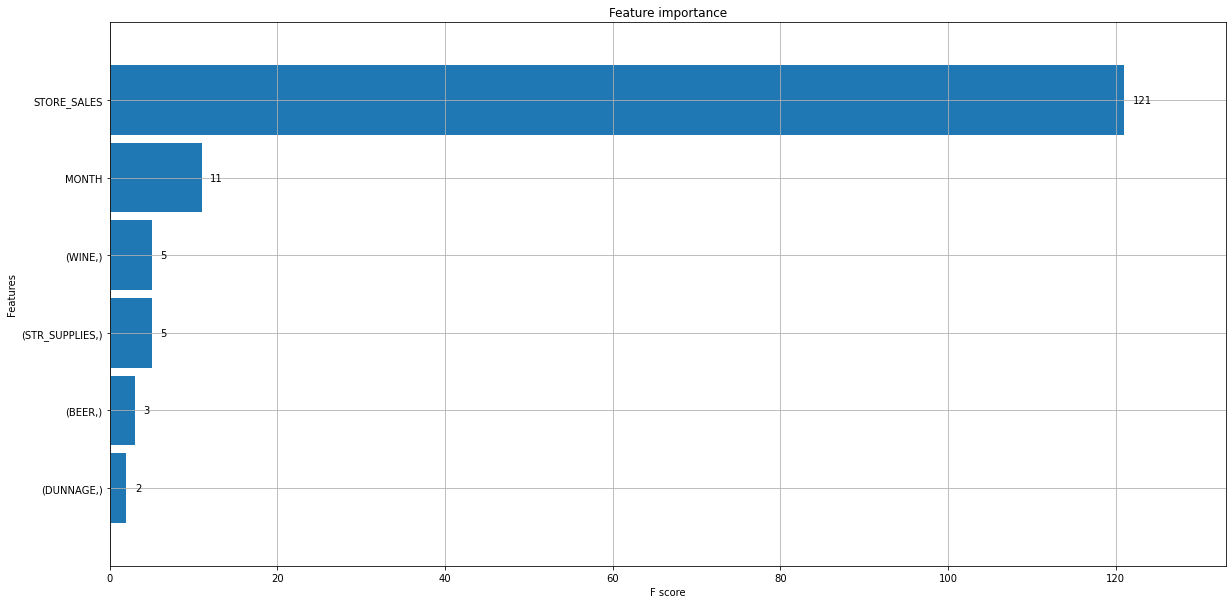

In [29]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(xgbr, height=0.9)

In [30]:
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
metr=metric(ytest, ypred)
mape=mean_absolute_percentage_error(ytest, ypred)
#print("Training score: ", score)

e:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [31]:
mse, mape, metr

(707198382.9451457, inf, 113.41241422282987)

# Модель со стандартизированными предикторами

In [ ]:
df1 = preprocessing.scale(df[[           'YEAR',           'MONTH',           'STORE_SALES',         ('WINE',),
             ('LIQUOR',),         ('BEER',), ('STR_SUPPLIES',),
                ('REF',),  ('NON-ALCOHOL',),         ('KEGS',),
            ('DUNNAGE',)]])

In [34]:
xtrain, xtest, ytrain, ytest=train_test_split(df1, df['SALES'], test_size=0.15)

In [35]:
xgbr = xgb.XGBRegressor() 
print(xgbr)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


In [36]:
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

In [37]:
kfold = KFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgbr, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold, verbose=1)
result = grid_search.fit(xtrain, ytrain)


Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.9min finished


In [38]:
print("Best: %f using %s" % (result.best_score_, result.best_params_))

Best: -636991492.983085 using {'max_depth': 2, 'n_estimators': 50}


In [39]:
xgbr = xgb.XGBRegressor(max_depth=2,n_estimators=50) 
xgbr.fit(xtrain, ytrain)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

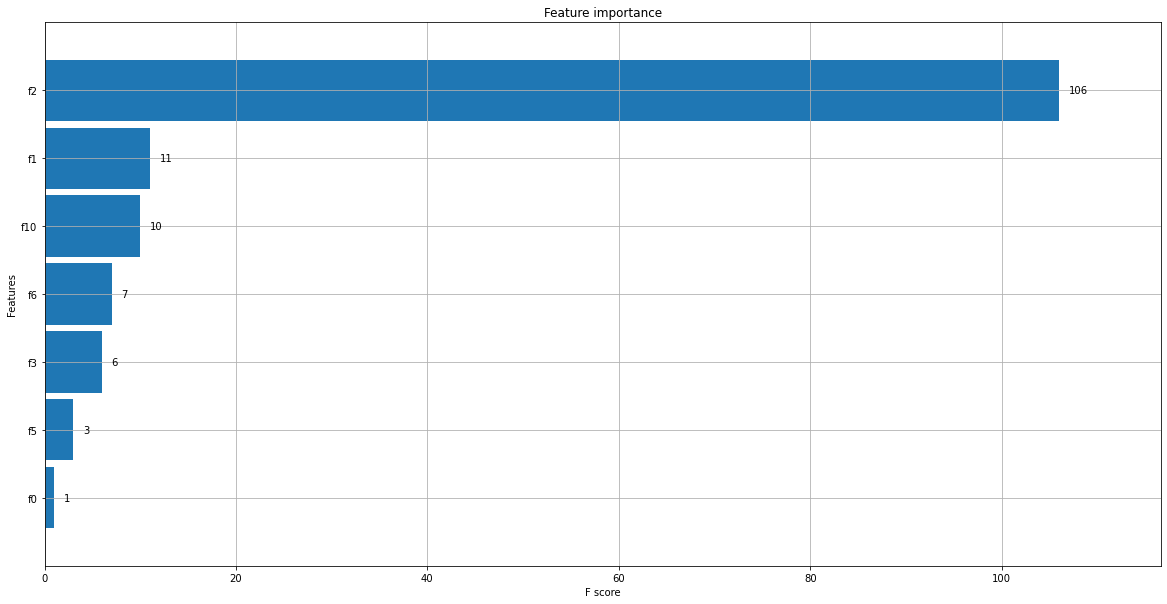

In [40]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(xgbr, height=0.9)

In [41]:
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
metr=metric(ytest, ypred)
mape=mean_absolute_percentage_error(ytest, ypred)
#print("Training score: ", score)

e:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [42]:
mse, mape, metr

(643717177.9927584, inf, 116.62618409703629)

# Добавим переменных

In [43]:
df#.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,"(WINE,)","(LIQUOR,)","(BEER,)","(STR_SUPPLIES,)","(REF,)","(NON-ALCOHOL,)","(KEGS,)","(DUNNAGE,)"
0,2017.0,4.0,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2017.0,4.0,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2017.0,4.0,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2017.0,4.0,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2017.0,4.0,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128325,2018.0,2.0,LABATT USA OPERATING CO LLC,99333,MAGIC HAT #9 1/2K,KEGS,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128326,2018.0,2.0,YUENGLING BREWERY,99350,YUENGLING LAGER 1/4K,KEGS,0.0,35.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
128327,2018.0,2.0,INTERBALT PRODUCTS CORP,99368,BALTIKA #8 NR 20/CS - 16.9OZ,BEER,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128328,2018.0,2.0,HAMCO DC,9938,THERMAL REGISTER PAPER,STR_SUPPLIES,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
ohe = OneHotEncoder(categories = "auto",sparse = False)
df.dropna(inplace=True)
tp=ohe.fit_transform(df[['CONTRAGENT']])
tp_col=pd.DataFrame(tp, columns=[df['CONTRAGENT'].unique()])
df = pd.concat([df,tp_col],axis = 1)
df.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,"(WINE,)","(LIQUOR,)",...,"(CHARLES JACQUIN ET CIE INC,)","(THE SANDY BOTTOM ENTERPRISES LLC,)","(SMITH-ANDERSON ENTERPRISES INC,)","(VINIFERA DISTRIBUTING OF MARYLAND INC,)","(PAMPA BEVERAGES LLC DBA TRANSNATIONAL SU,)","(DCD ENTERPRISES LLC,)","(BULLSHINE DISTILLERY LLC,)","(CASA CHIRICO LLC,)","(FREELANCE WINES LLC,)","(BLACK ANKLE VINEYARDS LLC,)"
0,2017.0,4.0,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017.0,4.0,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017.0,4.0,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017.0,4.0,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017.0,4.0,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
re.findall(r'\d{3}', 'GAMLA CAB - 750ML')

['750ML']

In [55]:
re.split(r'-', 'GAMLA CAB - 750ML')[-1]

' 750ML'

In [59]:
df['ARTICLE_NAME']

0                             GAMLA CAB - 750ML
1          SANTA MARGHERITA P/GRIG ALTO - 375ML
2         KNOB CREEK BOURBON 9YR - 100P - 375ML
3                 J W DANT BOURBON 100P - 1.75L
4                   RAMON CORDOVA RIOJA - 750ML
                          ...                  
128325                        MAGIC HAT #9 1/2K
128326                     YUENGLING LAGER 1/4K
128327             BALTIKA #8 NR 20/CS - 16.9OZ
128328                   THERMAL REGISTER PAPER
128329                    MAUDITE 6/4 NR - 12OZ
Name: ARTICLE_NAME, Length: 128330, dtype: object

In [75]:
#df['test']=df['ARTICLE_NAME'].apply(lambda x: re.split(r'-', x)[-1])
df.drop(columns='test', inplace=True)

In [84]:
df.isna().sum()
df.dropna(inplace=True)

In [85]:
x=df.columns
x

Index([                                       'YEAR',
                                             'MONTH',
                                        'CONTRAGENT',
                                      'ARTICLE_CODE',
                                      'ARTICLE_NAME',
                                     'ARTICLE_GROUP',
                                             'SALES',
                                       'STORE_SALES',
                                           ('WINE',),
                                         ('LIQUOR',),
       ...
                     ('CHARLES JACQUIN ET CIE INC',),
               ('THE SANDY BOTTOM ENTERPRISES LLC',),
                 ('SMITH-ANDERSON ENTERPRISES INC',),
          ('VINIFERA DISTRIBUTING OF MARYLAND INC',),
       ('PAMPA BEVERAGES LLC DBA TRANSNATIONAL SU',),
                            ('DCD ENTERPRISES LLC',),
                       ('BULLSHINE DISTILLERY LLC',),
                               ('CASA CHIRICO LLC',),
                 

In [86]:
x=list(x)
x1=[z for z in x if z not in ['CONTRAGENT', 'ARTICLE_CODE', 'ARTICLE_NAME', 'ARTICLE_GROUP', 'SALES']]


In [87]:
xtrain, xtest, ytrain, ytest=train_test_split(df[x1], df['SALES'], test_size=0.15)

e:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [89]:
xgbr = xgb.XGBRegressor() 
print(xgbr)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


In [90]:
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgbr, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold, verbose=1)
result = grid_search.fit(xtrain, ytrain)


In [ ]:
print("Best: %f using %s" % (result.best_score_, result.best_params_))

In [ ]:
xgbr = xgb.XGBRegressor(max_depth=2,n_estimators=50) 
xgbr.fit(xtrain, ytrain)


In [ ]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(xgbr, height=0.9)

In [ ]:
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
metr=metric(ytest, ypred)
mape=mean_absolute_percentage_error(ytest, ypred)
#print("Training score: ", score)

In [ ]:
mse, mape, metr

# Попробуем ускорить это все

In [97]:
df.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,"(WINE,)","(LIQUOR,)",...,"(CHARLES JACQUIN ET CIE INC,)","(THE SANDY BOTTOM ENTERPRISES LLC,)","(SMITH-ANDERSON ENTERPRISES INC,)","(VINIFERA DISTRIBUTING OF MARYLAND INC,)","(PAMPA BEVERAGES LLC DBA TRANSNATIONAL SU,)","(DCD ENTERPRISES LLC,)","(BULLSHINE DISTILLERY LLC,)","(CASA CHIRICO LLC,)","(FREELANCE WINES LLC,)","(BLACK ANKLE VINEYARDS LLC,)"
0,2017.0,4.0,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017.0,4.0,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017.0,4.0,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017.0,4.0,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017.0,4.0,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
from catboost import Pool, CatBoostRegressor
import catboost as cb

cbb = cb.CatBoostRegressor(eval_metric="MAPE", depth=10, iterations= 500, l2_leaf_reg= 9, learning_rate= 0.15,
                          cat_features=['CONTRAGENT', 'ARTICLE_GROUP'])
#clf = cbb()
#cbb.fit(df[['YEAR', 'MONTH', 'CONTRAGENT', 'ARTICLE_GROUP', 'STORE_SALES']],df['SALES'])
clf=cb.CatBoostRegressor(cat_features=['CONTRAGENT', 'ARTICLE_GROUP'])

In [ ]:
cbb.fit(df[['YEAR', 'MONTH', 'CONTRAGENT', 'ARTICLE_GROUP', 'STORE_SALES']],df['SALES'])

In [124]:
xtrain, xtest, ytrain, ytest=train_test_split(df[['YEAR', 'MONTH', 'CONTRAGENT', 'ARTICLE_GROUP', 'STORE_SALES']]
                                              , df['SALES'], test_size=0.15)

In [125]:
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
l2_leaf_reg=[x for x in range(9, 18)]
param_grid = dict(depth=max_depth, iterations=n_estimators, l2_leaf_reg=l2_leaf_reg)

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(clf, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold, verbose=1)
result = grid_search.fit(xtrain, ytrain)


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min


In [ ]:
print("Best: %f using %s" % (result.best_score_, result.best_params_))

In [ ]:
cbb1 = cb.CatBoostRegressor(eval_metric="MAPE", depth=10, iterations= 500, l2_leaf_reg= 9, learning_rate= 0.15,
                          cat_features=['CONTRAGENT', 'ARTICLE_GROUP'])
cbb1.fit(df[['YEAR', 'MONTH', 'CONTRAGENT', 'ARTICLE_GROUP', 'STORE_SALES']],df['SALES'])

In [106]:
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

ypred = cbb.predict(xtest[['YEAR', 'MONTH', 'CONTRAGENT', 
       'ARTICLE_GROUP', 'STORE_SALES']])
mse = mean_squared_error(ytest, ypred)
metr=metric(ytest, ypred)
mape=mean_absolute_percentage_error(ytest, ypred)

e:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [107]:
mse, metr, mape

(448966641.078883, 80.28110898203752, inf)